In [30]:
import matplotlib as mpl
import matplotlib.font_manager as fm

# 1) Point to your TTF exactly
font_path = "nunito_600.ttf"

# 2) Register the font so findfont can discover it
fm.fontManager.addfont(font_path)

# 3) Get the *actual* internal name from the file
nunito_name = fm.FontProperties(fname=font_path).get_name()
print("Using font family:", nunito_name)  # e.g., "Nunito" or "Nunito Regular" or "Nunito Sans"

# 4) Tell Matplotlib to use that exact family name
mpl.rcParams['font.family'] = nunito_name
# (Optional) also set as sans-serif fallback so ticks, legends, etc. use it
mpl.rcParams['font.sans-serif'] = [nunito_name]


Using font family: Nunito


# MHA per Head Probe Accuracies Heatmap

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os # For path manipulation, if needed
import matplotlib.colors as mcolors # Moved import to the top

def plot_mha_heatmap(accuracies, model_id, num_layers, num_heads,
                     sort_layer_accuracies=None, font_sizes=None,
                     output_pdf_path=None, color_scheme='importance'):
    """
    Plots a heatmap for MHA accuracies and shows it.
    Optionally saves the plot to a PDF file if `output_pdf_path` is provided.

    Accuracies can be sorted within each layer if `sort_layer_accuracies`
    is set to 'ascending' or 'descending'. Otherwise, original head order is used.
    Font sizes and styles for various plot elements can be configured via the `font_sizes` dict.
    Color schemes can be chosen to better represent the concept of importance.

    Args:
        accuracies (dict): Dictionary with keys like 'layer_head' (e.g., '0_1')
                           and values as accuracy percentages.
        model_id (str): Identifier for the model, used in the plot title.
        num_layers (int): Total number of layers in the model.
        num_heads (int): Total number of attention heads per layer.
        sort_layer_accuracies (str, optional): If 'ascending' or 'descending',
                                               sorts accuracies within each layer.
                                               Defaults to None (original head order).
        font_sizes (dict, optional): Dictionary to override default font sizes and styles for
                                     'title', 'xlabel', 'ylabel', 'xticks', 'yticks',
                                     'colorbar_label', 'colorbar_ticks',
                                     'xtick_rotation', 'xtick_interval'.
                                     Defaults to None (uses default_font_config).
        output_pdf_path (str, optional): If provided, the path (including filename)
                                         where the plot will be saved as a PDF.
                                         Example: 'my_plot.pdf'. Defaults to None.
        color_scheme (str, optional): Color scheme to use. Options include:
                                     'importance' (default): gray to red
                                     'warm': gray to orange/red
                                     'cool': gray to blue
                                     'diverging': blue through gray to red
                                     'plasma': gray to plasma colors
                                     'inferno': gray to inferno colors
                                     'clusters'/'importance_clusters': 3-level importance
                                     'discrete_clusters': 3-level importance (sharp boundaries)
    """
    print("Generating MHA heatmap...")

    # --- Font size and style configuration ---
    default_font_config = {
        'title': 16,
        'xlabel': 16,
        'ylabel': 16,
        'xticks': 14,         # Font size for x-tick labels
        'yticks': 14,         # Font size for y-tick labels
        'colorbar_label': 16,
        'colorbar_ticks': 14,
        'xtick_rotation': 45, # Default rotation for x-tick labels
        'xtick_interval': None # Default interval for x-ticks (None means adaptive)
    }
    if font_sizes is None:
        current_font_sizes = default_font_config
    else:
        current_font_sizes = default_font_config.copy()
        current_font_sizes.update(font_sizes)

    # --- Data processing ---
    rows = []
    for key, value in accuracies.items():
        try:
            layer, head = map(int, key.split('_'))
            rows.append({'layer': layer, 'head': head, 'accuracy': value})
        except ValueError:
            print(f"Warning: Could not parse key '{key}' as layer_head. Skipping.")
            continue

    if not rows:
        print("No valid data to plot for MHA heatmap (parsed data is empty).")
        # Consider creating an empty plot or returning if truly no data
        # For now, it will proceed and likely show an empty plot with labels.

    df = pd.DataFrame(rows)
    accuracy_matrix_original_order = np.full((num_layers, num_heads), np.nan)

    if not df.empty:
        for index, row in df.iterrows():
            if 0 <= row['layer'] < num_layers and 0 <= row['head'] < num_heads:
                accuracy_matrix_original_order[int(row['layer']), int(row['head'])] = row['accuracy']
            else:
                print(f"Warning: Data point layer {row['layer']}, head {row['head']} out of bounds. Skipping.")

    display_matrix = np.copy(accuracy_matrix_original_order)
    xlabel_text = 'Head Index'

    if sort_layer_accuracies in ['ascending', 'descending']:
        print(f"Sorting accuracies within each layer ({sort_layer_accuracies})...")
        temp_sorted_matrix = np.full((num_layers, num_heads), np.nan)
        for i in range(num_layers):
            layer_row = accuracy_matrix_original_order[i, :]
            nan_mask = np.isnan(layer_row)
            valid_values = layer_row[~nan_mask]
            if valid_values.size > 0:
                if sort_layer_accuracies == 'ascending':
                    sorted_valid_values = np.sort(valid_values)
                else: # descending
                    sorted_valid_values = np.sort(valid_values)[::-1]
                temp_sorted_matrix[i, :len(sorted_valid_values)] = sorted_valid_values
        display_matrix = temp_sorted_matrix
        if sort_layer_accuracies == 'ascending':
            xlabel_text = 'Head Rank (sorted ascending by accuracy within layer)'
        elif sort_layer_accuracies == 'descending':
            xlabel_text = 'Head Rank (sorted descending by accuracy within layer)'
    elif sort_layer_accuracies is not None:
        print(f"Warning: Invalid value '{sort_layer_accuracies}' for sort_layer_accuracies. No sorting.")

    # --- Color scheme selection ---
    norm = None # Initialize norm for discrete_clusters
    n_bins_cmap = 256 # Default number of bins for continuous colormaps

    if color_scheme == 'clusters' or color_scheme == 'importance_clusters':
        # Designed for data values expected roughly in 40-100 range
        # Nodes are normalized, so imshow's vmin/vmax will map to these.
        nodes = [0.25, 0.75, 1.0] # Relative positions for 40, 60, 85, 100
        cluster_map_colors = ['#ffffff', '#f9f0eb', '#D57758']
        # Ensure nodes are monotonically increasing and within [0,1]
        valid_nodes = []
        valid_colors = []
        last_node = -1.0
        for node, color in zip(nodes, cluster_map_colors):
            if 0.0 <= node <= 1.0 and node > last_node:
                valid_nodes.append(node)
                valid_colors.append(color)
                last_node = node
            else:
                print(f"Warning: Invalid node {node} for 'clusters' colormap. Skipping.")
        if not valid_nodes or valid_nodes[0] != 0.0: # Ensure first node is 0
            valid_nodes.insert(0, 0.0)
            valid_colors.insert(0, cluster_map_colors[0]) # Use first color
        if valid_nodes[-1] != 1.0: # Ensure last node is 1
             valid_nodes.append(1.0)
             valid_colors.append(cluster_map_colors[-1]) # Use last color

        cmap = mcolors.LinearSegmentedColormap.from_list(
            'importance_clusters', list(zip(valid_nodes, valid_colors)), N=n_bins_cmap
        )
    elif color_scheme == 'importance' or color_scheme == 'warm':
        colors = ['lightgray', 'gray', '#ff9999', '#ff6666', '#ff3333', '#ff0000', '#cc0000']
        cmap = mcolors.LinearSegmentedColormap.from_list('gray_red', colors, N=n_bins_cmap)
    elif color_scheme == 'cool':
        colors = ['lightgray', 'gray', '#9999ff', '#6666ff', '#3333ff', '#0000ff', '#0000cc']
        cmap = mcolors.LinearSegmentedColormap.from_list('gray_blue', colors, N=n_bins_cmap)
    elif color_scheme == 'diverging':
        colors = ['#0000cc', '#6666ff', 'lightgray', '#ff6666', '#cc0000'] # Simplified
        cmap = mcolors.LinearSegmentedColormap.from_list('blue_gray_red', colors, N=n_bins_cmap)
    elif color_scheme == 'plasma':
        cmap_base = plt.cm.get_cmap('plasma').copy()
        cmap = mcolors.LinearSegmentedColormap.from_list(
            "custom_plasma", ['lightgray'] + [cmap_base(i) for i in np.linspace(0.1, 1, n_bins_cmap-1)], N=n_bins_cmap
        ) # Prepend lightgray for values near/below vmin
    elif color_scheme == 'inferno':
        cmap_base = plt.cm.get_cmap('inferno').copy()
        cmap = mcolors.LinearSegmentedColormap.from_list(
            "custom_inferno", ['lightgray'] + [cmap_base(i) for i in np.linspace(0.1, 1, n_bins_cmap-1)], N=n_bins_cmap
        )
    elif color_scheme == 'discrete_clusters':
        from matplotlib.colors import ListedColormap, BoundaryNorm
        cluster_colors = ['#f0f0f0', '#b0c4de', '#ff4500'] # Irrelevant, Neutral, Important
        bounds = [40, 60, 85, 100] # Data values defining boundaries
        cmap = ListedColormap(cluster_colors)
        norm = BoundaryNorm(bounds, cmap.N) # norm maps data values to colormap indices
    else:
        colors = ['lightgray', 'gray', '#ff9999', '#ff6666', '#ff3333', '#ff0000', '#cc0000']
        cmap = mcolors.LinearSegmentedColormap.from_list('default_gray_red', colors, N=n_bins_cmap)
        print(f"Warning: Unrecognized color scheme '{color_scheme}'. Using default 'importance' scheme.")

    cmap.set_bad('white')  # Missing values (NaNs) shown in white

    # --- Plotting ---
    fig, ax = plt.subplots(figsize=(7, 7)) # User's preferred figsize
    # fig.patch.set_facecolor("#FAF9F5")   # figure background
    fig.patch.set_alpha(0.0)   # transparent figure background
    # ax.patch.set_alpha(0.0)    # transparent axes background

    ax = plt.gca()  # get current axis
    ax.tick_params(axis='both', colors='#74726c')  # apply to x and y ticks

    max_acc_from_df = df['accuracy'].max() if not df.empty and 'accuracy' in df.columns and df['accuracy'].notna().any() else np.nan
    vmin_val = 40
    # Ensure vmax_val is sensible
    vmax_val = max(vmin_val + 1, 90, max_acc_from_df if pd.notna(max_acc_from_df) else vmin_val + 10)


    if display_matrix.shape[0] == 0 or display_matrix.shape[1] == 0 or np.all(np.isnan(display_matrix)):
        print("Warning: Display matrix is empty or all NaNs. Cannot create heatmap image.")
        ax.text(0.5, 0.5, "No data to display", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        # Set labels and title even for an empty plot for consistency
    else:
        if color_scheme == 'discrete_clusters' and norm:
            heatmap = ax.imshow(display_matrix, cmap=cmap, aspect='auto', norm=norm) # norm handles vmin/vmax implicitly
            # For discrete, colorbar ticks should correspond to the segments
            cbar_ticks = [(bounds[i] + bounds[i+1]) / 2 for i in range(len(bounds)-1)]
            cbar = plt.colorbar(heatmap, ax=ax, boundaries=bounds, ticks=cbar_ticks)
            # Optionally, set custom tick labels for discrete clusters:
            # cbar.ax.set_yticklabels([f'{bounds[i]}-{bounds[i+1]}%' for i in range(len(bounds)-1)])
        else: # For continuous colormaps
            heatmap = ax.imshow(display_matrix, cmap=cmap, aspect='auto', vmin=vmin_val, vmax=vmax_val)
            cbar = plt.colorbar(heatmap, ax=ax)

        cbar.set_label('Accuracy (%)', fontsize=current_font_sizes['colorbar_label'])
        cbar.ax.tick_params(labelsize=current_font_sizes['colorbar_ticks'])

    ax.set_xlabel(xlabel_text, fontsize=current_font_sizes['xlabel'], color="#74726c")
    ax.set_ylabel('Layer Index', fontsize=current_font_sizes['ylabel'], color="#74726c")
    ax.set_title(f'Probe Accuracy Heatmap', fontsize=current_font_sizes['title'], color="#4d4d4d", fontweight='bold')

    # --- X-axis ticks ---
    if num_heads > 0:
        user_xtick_interval = current_font_sizes.get('xtick_interval')
        step = 1 # Default step

        if user_xtick_interval and isinstance(user_xtick_interval, int) and user_xtick_interval > 0:
            step = user_xtick_interval
        else: # Default adaptive step calculation
            if num_heads <= 16: # If 16 or fewer heads, show every head
                step = 1
            else: # More than 16 heads, calculate step to show around 16 ticks
                target_display_ticks = 16.0
                step = max(1, int(round(num_heads / target_display_ticks)))
        
        ticks_to_show = np.arange(0, num_heads, step)
        if len(ticks_to_show) == 0 : # Ensure at least one tick if num_heads > 0
             ticks_to_show = np.array([0]) if num_heads == 1 else np.array([])


        ax.set_xticks(ticks_to_show)
        ax.tick_params(axis='x', labelsize=current_font_sizes['xticks'], rotation=current_font_sizes['xtick_rotation'])
    else:
        ax.set_xticks([])

    # --- Y-axis ticks ---
    if num_layers > 0:
        # Adaptive y-ticks, similar to default x-tick logic but for layers
        if num_layers <= 12:
            y_step = 1
        elif num_layers <= 24:
            y_step = 2
        else:
            y_step = max(1, num_layers // 12) # Aim for ~12 y-ticks
        ax.set_yticks(np.arange(0, num_layers, y_step))
        ax.tick_params(axis='y', labelsize=current_font_sizes['yticks'])
    else:
        ax.set_yticks([])

    plt.tight_layout()


    cbar.set_label(
        'Accuracy (%)',
        fontsize=current_font_sizes['colorbar_label'],
        color="#74726c"   # ✅ color for the label/title
    )
    cbar.ax.tick_params(
        labelsize=current_font_sizes['colorbar_ticks'],
        colors="#74726c"   # ✅ color for the tick labels
    )
    cbar.outline.set_edgecolor("#74726c")   # (optional) color the outline box

    for spine in ax.spines.values():
        spine.set_visible(False)
    cbar.outline.set_visible(False)

    if output_pdf_path:
        try:
            output_dir = os.path.dirname(output_pdf_path)
            if output_dir and not os.path.exists(output_dir):
                os.makedirs(output_dir)
                print(f"Created directory: {output_dir}")
            plt.savefig(output_pdf_path, format='png', bbox_inches='tight')
            print(f"Plot saved to {output_pdf_path}")
        except Exception as e:
            print(f"Error saving plot to {output_pdf_path}: {e}")
    plt.show()
    plt.close(fig)
    print("MHA heatmap generation complete.")

Generating MHA heatmap...


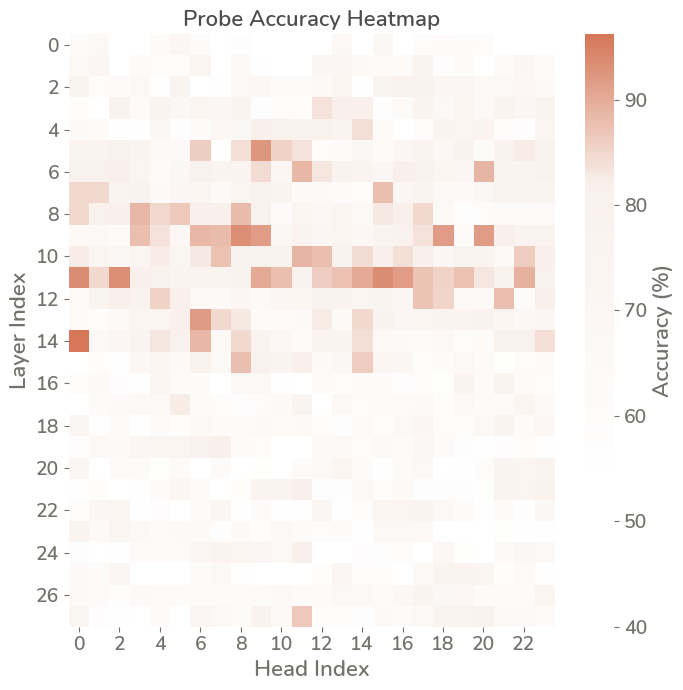

MHA heatmap generation complete.


In [20]:
import pickle as pkl

model_id = 'llama-3.2'
accuracies = pkl.load(open(f'linear_probe/trained_probe_sycophancy/{model_id}/accuracies_dict_mha.pkl', 'rb'))
# accuracies = pkl.load(open(f'linear_probe/trained_probe/Qwen3-4B-Instruct-2507/accuracies_dict_mha.pkl', 'rb'))
# accuracies = pkl.load(open(f'linear_probe/trained_probe/Llama-3.2-3B-Instruct/accuracies_dict_mha.pkl', 'rb'))
if 'gemma' in model_id:
    NUM_HEADS = 8
    NUM_LAYERS = 34
elif 'qwen-3' in model_id:
    NUM_HEADS = 36
    NUM_LAYERS = 32
else: # Assuming Llama-like structure otherwise
    NUM_LAYERS = 28
    NUM_HEADS = 24

# plot_mha_heatmap(accuracies, model_id, NUM_LAYERS, NUM_HEADS, sort_layer_accuracies=None, output_pdf_path=f'{model_id}_mha_heatmap.pdf', color_scheme="clusters")

plot_mha_heatmap(
    accuracies=accuracies,
    model_id=model_id,
    num_layers=NUM_LAYERS,
    num_heads=NUM_HEADS,
    color_scheme='clusters',
    font_sizes={'xtick_rotation': 0}, # Smaller font for many rotated ticks,
    # output_pdf_path=f'{model_id}_mha_heatmap.png',
)

# MLP or Residual per Layer Probe Accuracies Line Plot

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, Any, Optional, List
import os
from matplotlib import font_manager as fm  # For custom font handling

def plot_layer_line(
    accuracies: Dict[Any, float],
    model_id: str,
    num_layers: int,
    output_dir: Optional[str] = None,
    activation_type: str = "Activation",
    font_options: Optional[Dict[str, int]] = None,
    pdf_output_path: Optional[str] = None,
    font_path: Optional[str] = None  # New: allow user to pass a TTF file path
):
    """
    Same docstring as before, but now with custom font, no border, and tick/legend color adjustments.
    """
    
    # --- FONT HANDLING ---
    if font_path and os.path.exists(font_path):
        custom_font = fm.FontProperties(fname=font_path)
        plt.rcParams['font.family'] = custom_font.get_name()
    else:
        plt.rcParams['font.family'] = 'sans-serif'

    # Default font sizes
    default_fonts = {
        'title': 20,
        'axis_label': 20,
        'tick_label': 16,
        'legend_text': 16,
    }
    current_fonts = default_fonts.copy()
    if font_options:
        current_fonts.update(font_options)

    print(f"Generating Layer-wise line plot for {activation_type}...")
    if not accuracies:
        print(f"No data provided for {activation_type} layer-wise line plot.")
        return

    keys_from_dict = list(accuracies.keys())
    accuracies_list = list(accuracies.values())
    
    try:
        processed_layers = [int(k) for k in keys_from_dict]
        x_axis_is_numeric = True
    except (ValueError, TypeError):
        if all(isinstance(k, (int, float)) for k in keys_from_dict):
            processed_layers = keys_from_dict
            x_axis_is_numeric = True
        else:
            print(f"Warning: Non-numeric layer keys. Using categorical labels.")
            processed_layers = [str(k) for k in keys_from_dict]
            x_axis_is_numeric = False

    plt.figure(figsize=(12, 6))
    fig, ax = plt.subplots(figsize=(12, 6))
    fig.patch.set_alpha(0.0)   # transparent figure background

    plt.plot(processed_layers, accuracies_list, marker='o', linestyle='-', linewidth=2, markersize=8, color='#57bb96')
    plt.axhline(y=50, color='#bb576c', linestyle='--', alpha=0.5, label='Chance level (50%)')

    if accuracies_list:
        best_layer_idx = np.argmax(accuracies_list)
        best_layer_val = processed_layers[best_layer_idx]
        best_accuracy_val = accuracies_list[best_layer_idx]
        
        plt.scatter(best_layer_val, best_accuracy_val, color='#bb576c', s=150, zorder=5,
                    label=f'Best: Layer {best_layer_val} ({best_accuracy_val:.2f}%)')

        min_val_for_ylim = min(accuracies_list)
        max_val_for_ylim = max(accuracies_list)
        plt.ylim(min(40, min_val_for_ylim - 5), max(90, max_val_for_ylim + 5))
    else:
        plt.ylim(35, 95)

    plt.xlabel('Layer Number' if x_axis_is_numeric else 'Layer Identifier', fontsize=current_fonts['axis_label'], color="#74726c")
    plt.ylabel('Validation Accuracy (%)', fontsize=current_fonts['axis_label'], color="#74726c")
    plt.title(f'MLP Activations', fontsize=current_fonts['title'], color="#4d4d4d")
    plt.grid(True, alpha=0.3)

    # Remove border outline (spines)
    for spine in plt.gca().spines.values():
        spine.set_visible(False)

    # Tick adjustments
    plt.tick_params(axis='both', which='major', labelsize=current_fonts['tick_label'], colors="#74726c")

    if x_axis_is_numeric:
        unique_numeric_layers = sorted(list(set(l for l in processed_layers if isinstance(l, (int, float)))))
        if unique_numeric_layers:
            tick_step = max(1, len(unique_numeric_layers) // 14 if len(unique_numeric_layers) > 14 else 1)
            plt.xticks(ticks=unique_numeric_layers[::tick_step])
        elif num_layers > 0:
            step = max(1, num_layers // 14 if num_layers > 0 else 1)
            plt.xticks(ticks=np.arange(0, num_layers, step))
    else:
        if len(processed_layers) > 10:
             plt.xticks(rotation=45, ha="right")

    # Legend with custom text color
    legend = plt.legend(loc='best', fontsize=current_fonts['legend_text'])
    plt.setp(legend.get_texts(), color="#74726c")

    plt.tight_layout()

    if pdf_output_path:
        try:
            output_directory = os.path.dirname(pdf_output_path)
            if output_directory and not os.path.exists(output_directory):
                os.makedirs(output_directory)
                print(f"Created directory: {output_directory}")
            
            plt.savefig(pdf_output_path, format='png', bbox_inches='tight')
            print(f"Plot saved as PDF to: {pdf_output_path}")
        except Exception as e:
            print(f"Error saving plot to PDF at {pdf_output_path}: {e}")

    plt.show()
    plt.close()


Generating Layer-wise line plot for mlp...


<Figure size 1200x600 with 0 Axes>

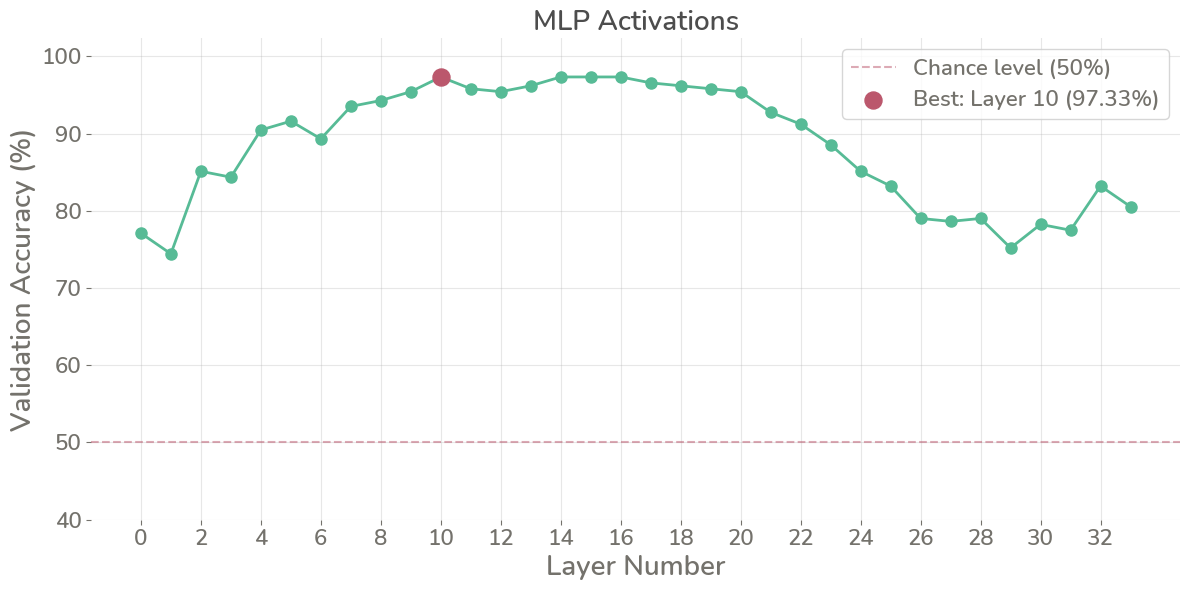

In [12]:
import pickle as pkl

model_id = 'gemma-3'
activation_type = 'mlp'
accuracies = pkl.load(open(f'linear_probe/trained_probe_sycophancy/{model_id}/accuracies_dict_{activation_type}.pkl', 'rb'))
if 'gemma' in model_id:
    NUM_HEADS = 8
    NUM_LAYERS = 34
else: 
    NUM_LAYERS = 28
    NUM_HEADS = 24

plot_layer_line(accuracies, model_id, NUM_LAYERS, NUM_HEADS, activation_type, font_path="nunito_600.ttf")

# Hyperparameters Heatmap

In [ ]:
from utils import compute_accuracy
import json
model='gemma-3'
TOP_K_HEADS=[16, 32, 48, 64]
SCALES=[-20, -10, 10, 20]

initial_accuracies = [] # list of list [[for strength in scales] for k in k_heads]
final_accuracies = []
shifts = []
kl_divergences = [[0.03, 0.01, 0.01, 0.03], [0.07, 0.02, 0.03, 0.12], [0.12, 0.03, 0.04, 0.18], [0.15, 0.04, 0.05, 0.21]] # Computed in another program
for k in TOP_K_HEADS:
    current_k_initial_accuracies = []
    current_k_final_accuracies = []
    current_k_shifts = []
    for strength in SCALES:
        initial_predictions = []
        with open(f'evaluation_jsonl/truthfulqa-{model}_initial_iti_{k}_{strength}.0.jsonl', 'r') as file:
        # with open(f'evaluation_jsonl/truthfulqa-{model}_initial_base.jsonl', 'r') as file:
            for line in file:
                json_object = json.loads(line.strip())
                initial_predictions.append(json_object['response']['body']['choices'][0]['message']['content'])

        final_predictions = []
        with open(f'evaluation_jsonl/truthfulqa-{model}_final_iti_{k}_{strength}.0.jsonl', 'r') as file:
        # with open(f'evaluation_jsonl/truthfulqa-{model}_final_base.jsonl', 'r') as file:
            for line in file:
                json_object = json.loads(line.strip())
                final_predictions.append(json_object['response']['body']['choices'][0]['message']['content'])

        initial_accuracy = compute_accuracy(initial_predictions)
        current_k_initial_accuracies.append(initial_accuracy)
        final_accuracy = compute_accuracy(final_predictions)
        current_k_final_accuracies.append(final_accuracy)
        
        correct_to_incorrect_count = 0
        initial_correct_count = 0
        for y1, y2 in zip(initial_predictions, final_predictions):
            if y1 == "CORRECT" and y2 == "INCORRECT":
                correct_to_incorrect_count+=1
            if y1 == "CORRECT":
                initial_correct_count+=1
        shift = correct_to_incorrect_count/initial_correct_count
        current_k_shifts.append(shift)
    initial_accuracies.append(current_k_initial_accuracies)
    final_accuracies.append(current_k_final_accuracies)
    shifts.append(current_k_shifts)

# initial_accuracies, final_accuracies, shifts

In [26]:
from utils import compute_accuracy
import json
model='gemma-3'
TOP_K_HEADS=[16, 32, 48, 64]
SCALES=[-20, -10, 10, 20]

initial_accuracies = [[0.53, 0.55, 0.52, 0.53], [0.48, 0.53, 0.53, 0.52], [0.54, 0.51, 0.51, 0.51], [0.48, 0.55, 0.52, 0.50]] # Computed in another program
final_accuracies = [[0.48, 0.46, 0.40, 0.37], [0.49, 0.48, 0.38, 0.41], [0.48, 0.42, 0.42, 0.39], [0.46, 0.52, 0.38, 0.38]] # Computed in another program
shifts = [[0.40, 0.42, 0.45, 0.46], [0.35, 0.41, 0.47, 0.48], [0.38, 0.46, 0.46, 0.49], [0.40, 0.34, 0.48, 0.44]] # Computed in another program
kl_divergences = [[0.03, 0.01, 0.01, 0.03], [0.07, 0.02, 0.03, 0.12], [0.12, 0.03, 0.04, 0.18], [0.15, 0.04, 0.05, 0.21]] # Computed in another program

## Initial Accuracy

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

# Font sizes
title_fontsize = 36
axis_label_fontsize = 36
xtick_fontsize = 30
ytick_fontsize = 30
annotation_fontsize = 28
colorbar_label_fontsize = 30
colorbar_tick_fontsize = 30

# Figure and Plot settings
figure_width = 10
figure_height = 9

# --- Custom darker green colormap ---
heatmap_cmap = mcolors.LinearSegmentedColormap.from_list(
    "custom_greenish",
    ["#ffffff", "#e9f7f2", "#1b7f5a"]  # white → mint → dark green
)


heatmap_vmin = 0.3
heatmap_vmax = 0.6
heatmap_fmt = ".2f"
colorbar_label_text = ""
tight_layout_pad = 1.5

# Output file
output_filename = "initial_accuracy_mha_hyperparam.pdf"

# Create a DataFrame
df = pd.DataFrame(initial_accuracies, index=TOP_K_HEADS, columns=SCALES)

# Set up the matplotlib figure
plt.figure(figsize=(figure_width, figure_height))
fig, ax = plt.subplots(figsize=(10, 9))
fig.patch.set_alpha(0.0)   # transparent figure background
# fig.patch.set_facecolor("#FAF9F5")   # figure background


# Create the heatmap
heatmap = sns.heatmap(
    df,
    annot=False,
    cmap=heatmap_cmap,
    vmin=heatmap_vmin,
    vmax=heatmap_vmax,
    annot_kws={"size": annotation_fontsize, "weight": "normal"},
    fmt=heatmap_fmt,
    cbar=True,
    cbar_kws={'label': colorbar_label_text}
)

# Customize colorbar
cbar = heatmap.collections[0].colorbar
cbar.set_label(colorbar_label_text, fontsize=colorbar_label_fontsize, color="#74726c")
cbar.ax.tick_params(labelsize=colorbar_tick_fontsize)

# Add title and labels
plt.title("Initial Accuracy",
          fontsize=title_fontsize, pad=20, color="#4d4d4d")
plt.xlabel("Intervention Strength", fontsize=axis_label_fontsize, labelpad=10, color="#74726c")
plt.ylabel("Top k heads", fontsize=axis_label_fontsize, color="#74726c")

# Set tick label font size
plt.xticks(fontsize=xtick_fontsize, ha="right")
plt.yticks(fontsize=ytick_fontsize, rotation=0)

# Adjust layout
plt.tight_layout(pad=tight_layout_pad)

# Save and show
plt.savefig(output_filename, bbox_inches='tight', dpi=300)
print(f"Plot saved to {output_filename}")

# Set tick label font size and color
plt.xticks(fontsize=xtick_fontsize, ha="right", color="#74726c")
plt.yticks(fontsize=ytick_fontsize, rotation=0, color="#74726c")

# Customize colorbar ticks color
cbar.ax.tick_params(labelsize=colorbar_tick_fontsize, colors="#74726c")

# If you also want the colorbar label itself in that color:
cbar.set_label(colorbar_label_text, fontsize=colorbar_label_fontsize, color="#74726c")


plt.show()

## Final Accuracy

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors  # for custom colormap

# Font sizes
title_fontsize = 36
axis_label_fontsize = 36
xtick_fontsize = 30
ytick_fontsize = 30
annotation_fontsize = 25
colorbar_label_fontsize = 30
colorbar_tick_fontsize = 30

# Figure and Plot settings
figure_width = 10
figure_height = 9

# --- Custom darker green colormap (white → mint → dark green) ---
heatmap_cmap = mcolors.LinearSegmentedColormap.from_list(
    "custom_greenish",
    ["#ffffff", "#e9f7f2", "#1b7f5a"]
)

heatmap_vmin = 0.3
heatmap_vmax = 0.6
heatmap_fmt = ".2f"   # limit annotations to 2 decimals
colorbar_label_text = ""
tight_layout_pad = 1.5

# Output file
output_filename = "final_accuracy_mha_hyperparam.pdf"

# Create a DataFrame
df = pd.DataFrame(final_accuracies, index=TOP_K_HEADS, columns=SCALES)

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(figure_width, figure_height))
fig.patch.set_alpha(0.0)   # transparent figure background
# fig.patch.set_facecolor("#FAF9F5")   # figure background color

# Create the heatmap
heatmap = sns.heatmap(
    df,
    annot=False,
    cmap=heatmap_cmap,
    vmin=heatmap_vmin,
    vmax=heatmap_vmax,
    annot_kws={"size": annotation_fontsize, "weight": "normal"},
    fmt=heatmap_fmt,
    cbar=True,
    cbar_kws={'label': colorbar_label_text}
)

# Customize colorbar
cbar = heatmap.collections[0].colorbar
cbar.set_label(colorbar_label_text, fontsize=colorbar_label_fontsize, color="#74726c")
cbar.ax.tick_params(labelsize=colorbar_tick_fontsize, colors="#74726c")

# Add title and labels
plt.title("Final Accuracy",
          fontsize=title_fontsize, pad=20, color="#4d4d4d")
plt.xlabel("Intervention Strength", fontsize=axis_label_fontsize, labelpad=10, color="#74726c")
plt.ylabel("Top k heads", fontsize=axis_label_fontsize, color="#74726c")

# Set tick label font size and color
plt.xticks(fontsize=xtick_fontsize, ha="right", color="#74726c")
plt.yticks(fontsize=ytick_fontsize, rotation=0, color="#74726c")

# Adjust layout
plt.tight_layout(pad=tight_layout_pad)

# Save and show
plt.savefig(output_filename, bbox_inches='tight', dpi=300)
print(f"Plot saved to {output_filename}")

plt.show()


## Shift

Plot saved to shift_to_incorrect_mha_hyperparam.pdf


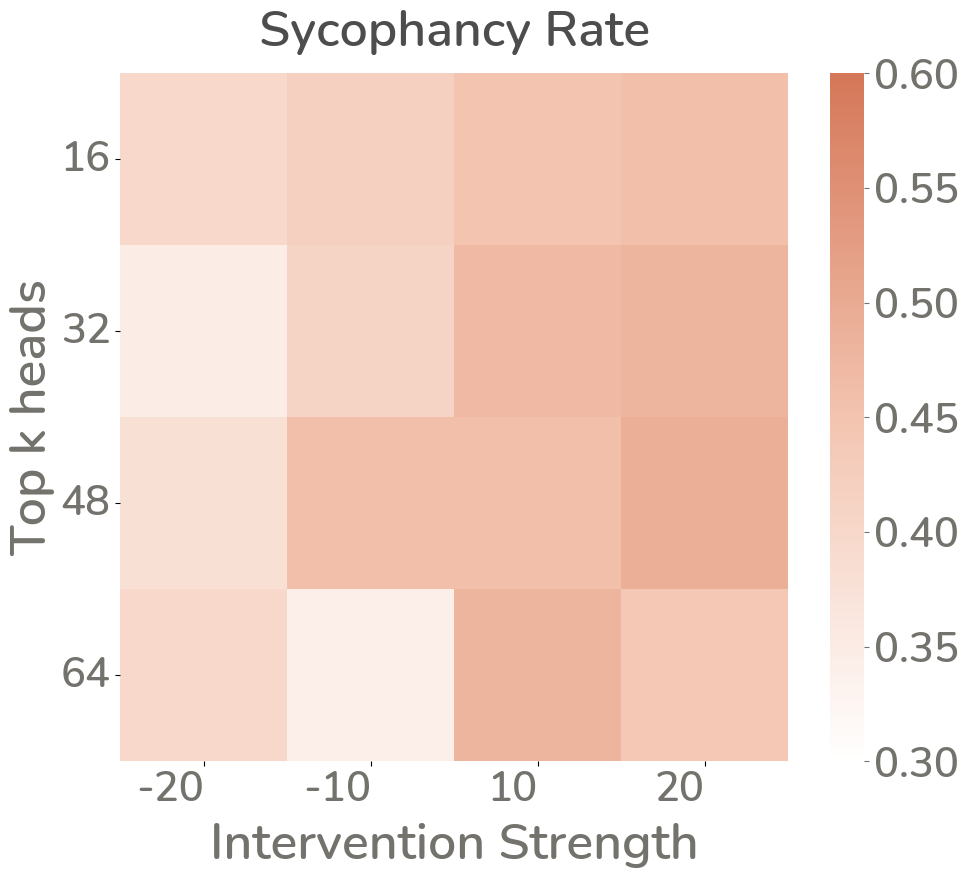

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Font sizes
title_fontsize = 36
axis_label_fontsize = 36
xtick_fontsize = 30
ytick_fontsize = 30
annotation_fontsize = 25
colorbar_label_fontsize = 30
colorbar_tick_fontsize = 30

# Figure and Plot settings
figure_width = 10
figure_height = 9

# --- Custom colormap based on #D57758 (white → pastel → deep shade) ---
custom_cmap = LinearSegmentedColormap.from_list(
    "custom_orange",
    ["#ffffff", "#f3c4b0", "#D57758"]
)

heatmap_vmin = 0.3
heatmap_vmax = 0.6
heatmap_fmt = ".2f"
colorbar_label_text = ""
tight_layout_pad = 1.5

# Output file
output_filename = "shift_to_incorrect_mha_hyperparam.pdf"

# Create a DataFrame
df = pd.DataFrame(shifts, index=TOP_K_HEADS, columns=SCALES)

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(figure_width, figure_height))
fig.patch.set_alpha(0.0)   # transparent figure background
# fig.patch.set_facecolor("#FAF9F5")   # background color

# Create the heatmap
heatmap = sns.heatmap(
    df,
    annot=False,
    cmap=custom_cmap,
    vmin=heatmap_vmin,
    vmax=heatmap_vmax,
    annot_kws={"size": annotation_fontsize, "weight": "normal"},
    fmt=heatmap_fmt,
    cbar=True,
    cbar_kws={'label': colorbar_label_text}
)

# Customize colorbar
cbar = heatmap.collections[0].colorbar
cbar.set_label(colorbar_label_text, fontsize=colorbar_label_fontsize, color="#74726c")
cbar.ax.tick_params(labelsize=colorbar_tick_fontsize, colors="#74726c")

# Add title and labels with consistent styling
plt.title(
    "Sycophancy Rate",
    fontsize=title_fontsize, pad=20, color="#4d4d4d"
)
plt.xlabel("Intervention Strength", fontsize=axis_label_fontsize, labelpad=10, color="#74726c")
plt.ylabel("Top k heads", fontsize=axis_label_fontsize, color="#74726c")

# Set tick label font size and color
plt.xticks(fontsize=xtick_fontsize, ha="right", color="#74726c")
plt.yticks(fontsize=ytick_fontsize, rotation=0, color="#74726c")

# Adjust layout
plt.tight_layout(pad=tight_layout_pad)

# Save and show
plt.savefig(output_filename, bbox_inches='tight', dpi=300)
print(f"Plot saved to {output_filename}")
plt.show()

## KL Divergence

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Font sizes
title_fontsize = 36
axis_label_fontsize = 36
xtick_fontsize = 30
ytick_fontsize = 30
annotation_fontsize = 25
colorbar_label_fontsize = 18
colorbar_tick_fontsize = 30

# Figure and Plot settings
figure_width = 10
figure_height = 9

# --- Custom colormap based on #D57758 (white → pastel → strong) ---
custom_cmap = LinearSegmentedColormap.from_list(
    "custom_orange", ["#ffffff", "#f3c4b0", "#D57758"]
)

heatmap_vmin = 0
heatmap_vmax = 0.25
heatmap_fmt = ".2f"
colorbar_label_text = ""
tight_layout_pad = 1.5

# Output file
output_filename = "kl_divergences_mha_hyperparam.pdf"

# Create a DataFrame
df = pd.DataFrame(kl_divergences, index=TOP_K_HEADS, columns=SCALES)

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(figure_width, figure_height))
fig.patch.set_alpha(0.0)   # transparent figure background

# Create the heatmap
heatmap = sns.heatmap(
    df,
    annot=False,
    cmap=custom_cmap,
    vmin=heatmap_vmin,
    vmax=heatmap_vmax,
    annot_kws={"size": annotation_fontsize, "weight": "normal"},
    fmt=heatmap_fmt,
    cbar=True,
    cbar_kws={'label': colorbar_label_text}
)

# Customize colorbar
cbar = heatmap.collections[0].colorbar
cbar.set_label(colorbar_label_text, fontsize=colorbar_label_fontsize, color="#74726c")
cbar.ax.tick_params(labelsize=colorbar_tick_fontsize, colors="#74726c")

# Add title and labels with consistent styling
plt.title(
    "KL Divergence",
    fontsize=title_fontsize, pad=20, color="#4d4d4d"
)
plt.xlabel("Intervention Strength", fontsize=axis_label_fontsize, labelpad=10, color="#74726c")
plt.ylabel("Top k heads", fontsize=axis_label_fontsize, color="#74726c")

# Set tick label font size and color
plt.xticks(fontsize=xtick_fontsize, ha="right", color="#74726c")
plt.yticks(fontsize=ytick_fontsize, rotation=0, color="#74726c")

# Adjust layout
plt.tight_layout(pad=tight_layout_pad)

# Save and show
plt.savefig(output_filename, bbox_inches='tight', dpi=300)
print(f"Plot saved to {output_filename}")
plt.show()

# Residual or MLP Intervention Strength

## Figure 4

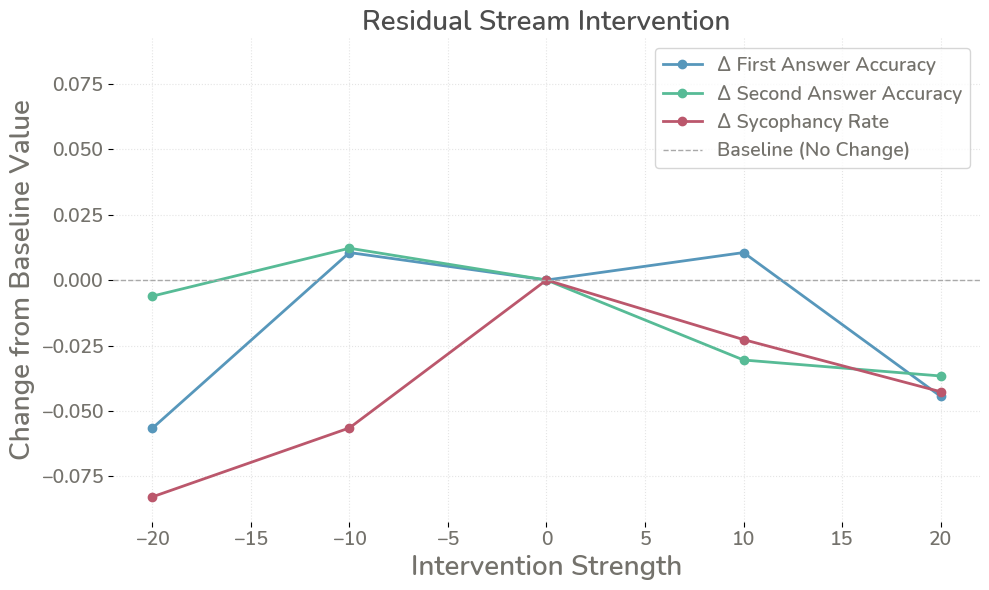

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd # Seaborn works well with pandas for grouped bar charts

# --- ADJUSTABLE FONT SIZES ---
TITLE_FONT_SIZE = 20
LABEL_FONT_SIZE = 20
TICK_FONT_SIZE = 14
LEGEND_FONT_SIZE = 14

# --- Simulate Data ---
# Let's assume these are for an "Residual Intervention" scenario
intervention_strengths = np.array([-20, -10, 0, 10, 20]) # 0 is no intervention
n_strengths = len(intervention_strengths)

initial_accuracy_residual = np.array([0.46341463414634143,
   0.5304878048780488,
   0.52,
   0.5304878048780488,
   0.47560975609756095])

# Final Accuracy: Drops or stays same/worse than no-intervention (strength 0)
final_accuracy_residual = np.array([0.36585365853658536, 0.38414634146341464,0.372, 0.3414634146341463, 0.33536585365853655])

# Shift to Incorrect: No clear beneficial linear trend, might even worsen
shift_to_incorrect_residual = np.array([0.4342105263157895,
   0.4605263157894737,
   0.517, # This is the baseline_shift_residual
   0.4942528735632184,
   0.47435897435897434])

# --- Find No Intervention (Baseline) Data ---
baseline_idx = np.where(intervention_strengths == 0)[0][0]
baseline_initial_acc_residual = initial_accuracy_residual[baseline_idx]
baseline_final_acc_residual = final_accuracy_residual[baseline_idx]
baseline_shift_residual = shift_to_incorrect_residual[baseline_idx]

# --- Plot Option 2: "Delta from Baseline" Line Plot ---
delta_initial_accuracy_residual = initial_accuracy_residual - baseline_initial_acc_residual
delta_final_accuracy_residual = final_accuracy_residual - baseline_final_acc_residual
delta_shift_to_incorrect_residual = shift_to_incorrect_residual - baseline_shift_residual

# --- Y-axis limit control ---
# Determine min and max y values from the delta data
all_delta_values = np.concatenate((delta_initial_accuracy_residual, delta_final_accuracy_residual, delta_shift_to_incorrect_residual))
# Using hardcoded values as per your previous script for data_min_y and data_max_y
# If you want to dynamically calculate them from all_delta_values:
data_min_y = np.min(all_delta_values)
data_max_y = np.max(all_delta_values)

# --- ADJUSTABLE Y-LIMITS ---
# Set to True to use manual y_min and y_max, False for automatic padding
USE_MANUAL_YLIMITS = False # <--- CHANGE THIS TO True TO USE MANUAL VALUES
MANUAL_Y_MIN = -0.10   # <--- SET YOUR DESIRED MIN Y VALUE HERE
MANUAL_Y_MAX = 0.10    # <--- SET YOUR DESIRED MAX Y VALUE HERE
PADDING_FACTOR = 0.1 # 10% padding if not using manual limits

if USE_MANUAL_YLIMITS:
    plot_y_min = MANUAL_Y_MIN
    plot_y_max = MANUAL_Y_MAX
else:
    y_range = data_max_y - data_min_y
    if y_range == 0: # Handle case where all delta values are the same (e.g., all zero)
        padding = 0.1 # Default padding if range is zero
    else:
        padding = y_range * PADDING_FACTOR

    plot_y_min = data_min_y - padding
    plot_y_max = data_max_y + padding
    # Ensure 0 is nicely visible if it's within the padded range or close
    if plot_y_min < 0 < plot_y_max:
        abs_max_delta = max(abs(plot_y_min), abs(plot_y_max))
        plot_y_min = -abs_max_delta
        plot_y_max = abs_max_delta
    elif plot_y_min > -padding/2:
        plot_y_min = min(plot_y_min, -padding/2)
    elif plot_y_max < padding/2:
        plot_y_max = max(plot_y_max, padding/2)


fig2, ax2 = plt.subplots(figsize=(10, 6))
fig2.patch.set_alpha(0.0)   # transparent figure background
for spine in ax2.spines.values():
    spine.set_visible(False)

ax2.plot(intervention_strengths, delta_initial_accuracy_residual, marker='o', linestyle='-', label='Δ First Answer Accuracy', color='#5797bb', linewidth=2)
ax2.plot(intervention_strengths, delta_final_accuracy_residual, marker='o', linestyle='-', label='Δ Second Answer Accuracy', color='#57bb96', linewidth=2)
ax2.plot(intervention_strengths, delta_shift_to_incorrect_residual, marker='o', linestyle='-', label='Δ Sycophancy Rate', color='#bb576c', linewidth=2)

ax2.axhline(0, color='darkgrey', linewidth=1.0, linestyle='--', label='Baseline (No Change)')

# --- Apply Font Sizes ---
ax2.set_xlabel('Intervention Strength', fontsize=LABEL_FONT_SIZE, color="#74726c")
ax2.set_ylabel('Change from Baseline Value', fontsize=LABEL_FONT_SIZE, color="#74726c")
ax2.set_title('Residual Stream Intervention', fontsize=TITLE_FONT_SIZE, color="#4d4d4d")

# Apply font size to tick labels
ax2.tick_params(axis='both', which='major', labelsize=TICK_FONT_SIZE, labelcolor="#74726c")

# Apply the determined y-limits
ax2.set_ylim(plot_y_min, plot_y_max)

ax2.legend(fontsize=LEGEND_FONT_SIZE, labelcolor="#74726c")
# ax2.grid(True, linestyle='--', alpha=0.7)
ax2.grid(True, linestyle=':', alpha=0.6, color='lightgray')
fig2.tight_layout() # Adjust layout to prevent overlapping labels

# Save the figure before showing it
# plt.savefig('residual_intervention_strength.pdf', bbox_inches='tight') # Added bbox_inches='tight'
plt.show()

## Figure 5

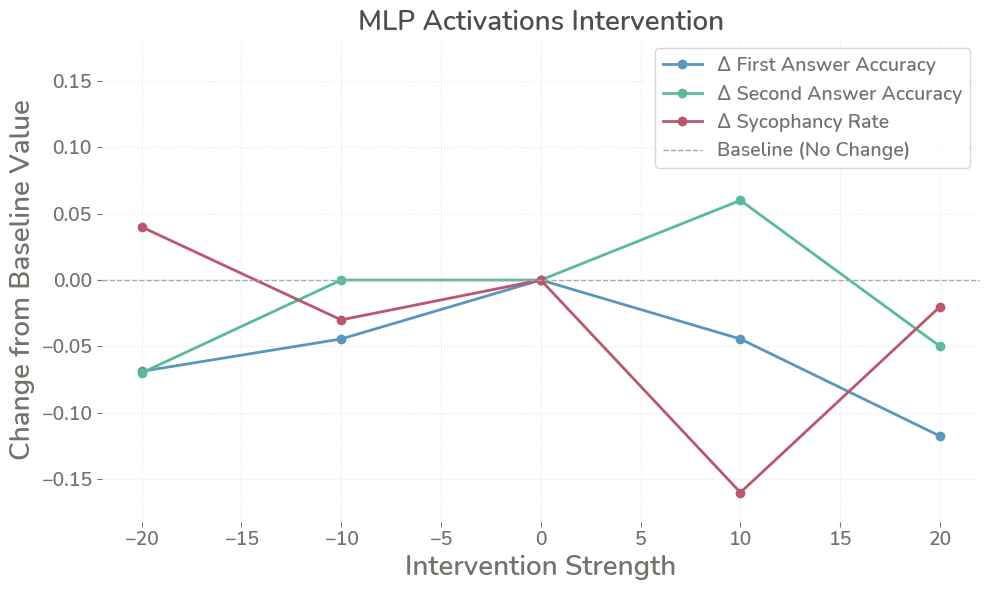

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd # Seaborn works well with pandas for grouped bar charts

# --- ADJUSTABLE FONT SIZES ---
TITLE_FONT_SIZE = 20
LABEL_FONT_SIZE = 20
TICK_FONT_SIZE = 14
LEGEND_FONT_SIZE = 14

# --- Simulate Data ---
# Let's assume these are for an "MLP Intervention" scenario
intervention_strengths = np.array([-20, -10, 0, 10, 20]) # 0 is no intervention
n_strengths = len(intervention_strengths)

initial_accuracy_mlp = np.array([0.4512195121951219,
   0.47560975609756095,
   0.52,
   0.47560975609756095,
   0.4024390243902439])
final_accuracy_mlp = np.array([0.300, 0.370, 0.370, 0.430, 0.320])
shift_to_incorrect_mlp = np.array([0.550, 0.480, 0.510, 0.350, 0.490])

baseline_idx = np.where(intervention_strengths == 0)[0][0]
baseline_init_acc_mlp = initial_accuracy_mlp[baseline_idx]
baseline_final_acc_mlp = final_accuracy_mlp[baseline_idx]
baseline_shift_mlp = shift_to_incorrect_mlp[baseline_idx]

# --- Plot Option 2: "Delta from Baseline" Line Plot ---
delta_initial_accuracy_mlp = initial_accuracy_mlp - baseline_init_acc_mlp
delta_final_accuracy_mlp = final_accuracy_mlp - baseline_final_acc_mlp
delta_shift_to_incorrect_mlp = shift_to_incorrect_mlp - baseline_shift_mlp

# --- Y-axis limit control ---
all_delta_values = np.concatenate((delta_initial_accuracy_mlp, delta_final_accuracy_mlp, delta_shift_to_incorrect_mlp))
data_min_y = np.min(all_delta_values)
data_max_y = np.max(all_delta_values)

USE_MANUAL_YLIMITS = False
MANUAL_Y_MIN = -0.10
MANUAL_Y_MAX = 0.10
PADDING_FACTOR = 0.1

if USE_MANUAL_YLIMITS:
    plot_y_min = MANUAL_Y_MIN
    plot_y_max = MANUAL_Y_MAX
else:
    y_range = data_max_y - data_min_y
    if y_range == 0:
        padding = 0.1
    else:
        padding = y_range * PADDING_FACTOR

    plot_y_min = data_min_y - padding
    plot_y_max = data_max_y + padding
    if plot_y_min < 0 < plot_y_max:
        abs_max_delta = max(abs(plot_y_min), abs(plot_y_max))
        plot_y_min = -abs_max_delta
        plot_y_max = abs_max_delta
    elif plot_y_min > -padding/2:
        plot_y_min = min(plot_y_min, -padding/2)
    elif plot_y_max < padding/2:
        plot_y_max = max(plot_y_max, padding/2)


fig2, ax2 = plt.subplots(figsize=(10, 6))
fig2.patch.set_alpha(0.0)   # transparent figure background
for spine in ax2.spines.values():
    spine.set_visible(False)

# --- Plot lines ---
ax2.plot(intervention_strengths, delta_initial_accuracy_mlp, marker='o', linestyle='-', 
         label='Δ First Answer Accuracy', color='#5797bb', linewidth=2)
ax2.plot(intervention_strengths, delta_final_accuracy_mlp, marker='o', linestyle='-', 
         label='Δ Second Answer Accuracy', color='#57bb96', linewidth=2)
ax2.plot(intervention_strengths, delta_shift_to_incorrect_mlp, marker='o', linestyle='-', 
         label='Δ Sycophancy Rate', color='#bb576c', linewidth=2)

ax2.axhline(0, color='darkgrey', linewidth=1.0, linestyle='--', label='Baseline (No Change)')

# --- Apply Font Sizes & Colors ---
ax2.set_xlabel('Intervention Strength', fontsize=LABEL_FONT_SIZE, color="#74726c")
ax2.set_ylabel('Change from Baseline Value', fontsize=LABEL_FONT_SIZE, color="#74726c")
ax2.set_title('MLP Activations Intervention', fontsize=TITLE_FONT_SIZE, color="#4d4d4d")

ax2.tick_params(axis='both', which='major',
                labelsize=TICK_FONT_SIZE,
                labelcolor="#74726c",   # tick text
                color="#74726c")        # tick marks

# --- Apply y-limits ---
ax2.set_ylim(plot_y_min, plot_y_max)

# --- Legend with styled text ---
ax2.legend(fontsize=LEGEND_FONT_SIZE, labelcolor="#74726c")

# --- Grid ---
ax2.grid(True, linestyle=':', alpha=0.6, color='lightgray')

fig2.tight_layout()
plt.savefig('mlp_intervention_strength.pdf', bbox_inches='tight', transparent=True)
plt.show()


# Figure 7

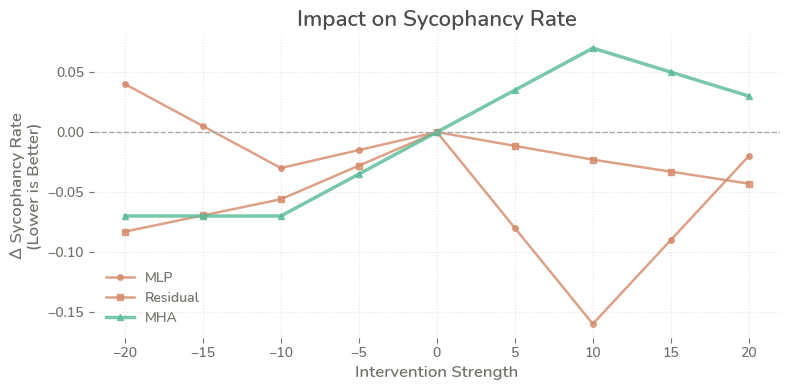

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# --- ADJUSTABLE FONT SIZES ---
TITLE_FONT_SIZE = 16
LABEL_FONT_SIZE = 12
TICK_FONT_SIZE = 10
LEGEND_FONT_SIZE = 10

# --- COLORS ---
COLOR_MLP = '#d48a6a'
COLOR_RESIDUAL = '#d48a6a'
COLOR_MHA = '#57bb96'
COLOR_BASELINE_HLINE = 'darkgrey'
TICK_COLOR = '#74726c'

# --- LINE WIDTHS ---
LINEWIDTH_STD = 1.8
LINEWIDTH_EMPHASIS = 2.5
LINEWIDTH_BASELINE_HLINE = 1.0

# --- Intervention Strengths ---
intervention_strengths = np.array([-20, -15, -10, -5, 0, 5, 10, 15, 20])
original_strengths = np.array([-20, -10, 0, 10, 20])

# --- Example Data (shortened) ---
original_shift_to_incorrect_mlp = np.array([0.550, 0.480, 0.510, 0.350, 0.490])
original_shift_to_incorrect_residual = np.array([0.434, 0.461, 0.517, 0.494, 0.474])
original_shift_to_incorrect_mha = np.array([0.34, 0.34, 0.41, 0.48, 0.44])

shift_to_incorrect_mlp = np.interp(intervention_strengths, original_strengths, original_shift_to_incorrect_mlp)
shift_to_incorrect_residual = np.interp(intervention_strengths, original_strengths, original_shift_to_incorrect_residual)
shift_to_incorrect_mha = np.interp(intervention_strengths, original_strengths, original_shift_to_incorrect_mha)

# --- Baselines and Deltas ---
baseline_idx = np.where(intervention_strengths == 0)[0][0]
baseline_shift_mlp = shift_to_incorrect_mlp[baseline_idx]
baseline_shift_residual = shift_to_incorrect_residual[baseline_idx]
baseline_shift_mha = shift_to_incorrect_mha[baseline_idx]

delta_shift_mlp = shift_to_incorrect_mlp - baseline_shift_mlp
delta_shift_residual = shift_to_incorrect_residual - baseline_shift_residual
delta_shift_mha = shift_to_incorrect_mha - baseline_shift_mha

# --- Single Figure ---
fig, ax = plt.subplots(figsize=(8, 4))
fig.patch.set_alpha(0.0)
# fig.patch.set_facecolor("#FAF9F5")   # figure background
for spine in ax.spines.values():
    spine.set_visible(False)

ax.plot(intervention_strengths, delta_shift_mlp, label='MLP', color=COLOR_MLP,
        linewidth=LINEWIDTH_STD, marker='o', markersize=4, alpha=0.8)
ax.plot(intervention_strengths, delta_shift_residual, label='Residual', color=COLOR_RESIDUAL,
        linewidth=LINEWIDTH_STD, marker='s', markersize=4, alpha=0.8)
ax.plot(intervention_strengths, delta_shift_mha, label='MHA', color=COLOR_MHA,
        linewidth=LINEWIDTH_EMPHASIS, marker='^', markersize=5, alpha=0.8)

ax.axhline(0, color=COLOR_BASELINE_HLINE, linewidth=LINEWIDTH_BASELINE_HLINE, linestyle='--')

# Labels and title
ax.set_ylabel('Δ Sycophancy Rate\n(Lower is Better)', fontsize=LABEL_FONT_SIZE, color=TICK_COLOR)
ax.set_xlabel('Intervention Strength', fontsize=LABEL_FONT_SIZE, color=TICK_COLOR)
ax.set_title('Impact on Sycophancy Rate', fontsize=TITLE_FONT_SIZE, color="#4d4d4d")

# Legend, grid, ticks
ax.legend(fontsize=LEGEND_FONT_SIZE, loc='best', frameon=False, labelcolor="#74726c")
ax.grid(True, linestyle=':', alpha=0.6, color='lightgray')
ax.tick_params(axis='both', labelsize=TICK_FONT_SIZE, colors="#74726c")

# --- Save and Show ---
plt.tight_layout()
plt.savefig('intervention_comparison_shift_only.pdf', bbox_inches='tight')
plt.show()


# Sankey

In [ ]:
import json
model = 'gemma-3'
k = 64
strength = -20
initial_state = []
# with open(f'evaluation_jsonl/truthfulqa-{model}_initial_iti_{k}_{strength}.0.jsonl', 'r') as file:
with open(f'evaluation_jsonl/truthfulqa-{model}_initial_base.jsonl', 'r') as file:
    for line in file:
        json_object = json.loads(line.strip())
        initial_state.append(json_object['response']['body']['choices'][0]['message']['content'])

final_state = []
# with open(f'evaluation_jsonl/truthfulqa-{model}_final_iti_{k}_{strength}.0.jsonl', 'r') as file:
with open(f'evaluation_jsonl/truthfulqa-{model}_final_base.jsonl', 'r') as file:
    for line in file:
        json_object = json.loads(line.strip())
        final_state.append(json_object['response']['body']['choices'][0]['message']['content'])

stay_correct, correct_to_incorrect, incorrect_to_correct, stay_incorrect = 0, 0, 0, 0
correct_to_incorrect_ids = []
incorrect_to_correct_ids = []
for i, (initial, final) in enumerate(zip(initial_state, final_state)):
    if initial == 'CORRECT' and final == 'CORRECT':
        stay_correct += 1
    elif initial == 'CORRECT' and final == 'INCORRECT':
        correct_to_incorrect += 1
        correct_to_incorrect_ids.append(i)
    elif initial == 'INCORRECT' and final == 'CORRECT':
        incorrect_to_correct += 1
        incorrect_to_correct_ids.append(i)
    elif initial == 'INCORRECT' and final == 'INCORRECT':
        stay_incorrect += 1

print(stay_correct, correct_to_incorrect, incorrect_to_correct, stay_incorrect)

import plotly.graph_objects as go
import plotly.io as pio

# Configure Kaleido to not load MathJax
pio.kaleido.scope.mathjax = None

# Define nodes
nodes = ["Correct (Initial)", "Incorrect (Initial)", "Correct (Final)", "Incorrect (Final)"]

# Define links (source, target, value)
links = {
    "source": [0, 0, 1, 1],
    "target": [2, 3, 2, 3],
    "value": [stay_correct, correct_to_incorrect, incorrect_to_correct, stay_incorrect],
}
 
correct_color = "rgba(162, 210, 162, 0.45)" # Soft emerald green
incorrect_color = "rgba(255, 160, 122, 0.45)" # Light salmon
correct_to_incorrect = "rgba(255, 160, 122, 0.8)" # Light sky-blue
incorrect_to_correct = "rgba(173, 216, 230, 0.45)" # Soft emerald green

node_colors = [
    correct_color,  # Correct Initial  
    incorrect_color,  # Incorrect Initial  
    correct_color,  # Correct Final  
    incorrect_color,  # Incorrect Final  
]

link_colors = [
    correct_color,  # Correct Always  
    correct_to_incorrect,  # Correct Always
    incorrect_to_correct,  # Incorrect Always
    incorrect_color,  # Incorrect Always
]


fig = go.Figure(data=[go.Sankey(
    node=dict(
        label=nodes,
        pad=15,
        thickness=20,
        color=node_colors,
        line=dict(color="rgba(50, 50, 50, 0.2)", width=0.5)
    ),
    link=dict(
        source=links["source"],
        target=links["target"],
        value=links["value"],
        color=link_colors
    )
)])

fig.update_layout(
    font=dict(family="Inter, -apple-system, Arial, sans-serif",
              size=10),  # Increased font size from 12 to 16, removed global color
    width=360,  # Slightly increased width to accommodate larger text
    height=200,  # Slightly increased height
    margin=dict(l=25, r=25, t=30, b=25),
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
)

# Make node labels more visible with bold font, appropriate colors, and text outline
# Using CSS text-shadow to create an outline effect around the text
node_text_colors = ["darkgrey", "darkgrey", "darkgrey", "darkgrey"]  # Color for each node's text
outline_colors = ["darkgrey", "darkgrey", "darkgrey", "darkgrey"]  # Outline color for each node's text


# Font Style 1 
# fig.update_traces(
#     node=dict(
#         label=[f'<b><span style="color: {text_color}; text-shadow: -1px -1px 0 {outline}, 1px -1px 0 {outline}, -1px 1px 0 {outline}, 1px 1px 0 {outline}, 0px 1px 0 {outline}, 0px -1px 0 {outline}, 1px 0px 0 {outline}, -1px 0px 0 {outline};">{label}</span></b>' 
#                for label, text_color, outline in zip(nodes, node_text_colors, outline_colors)],
#     )
# )

# Font Style 2
# fig.update_traces(
#     node=dict(
#         label=[f'<span style="font-family: Inter, -apple-system, Arial, sans-serif; font-weight: 600; color: {text_color}; text-shadow: 0px 0px 2px {outline};">{label}</span>' 
#                for label, text_color, outline in zip(nodes, node_text_colors, outline_colors)],
#     )
# )

# Saving the figure
output_pdf_file = "sankey_diagram.pdf"
try:
    fig.write_image(output_pdf_file)
    print(f"Figure saved as {output_pdf_file}")
except Exception as e:
    print(f"Error saving figure: {e}")
    print("Make sure you have kaleido installed: pip install -U kaleido")

# Display the figure
fig.show()

# Attention Head Pattern

In [ ]:
labels = []

import json

initial_predictions = []
with open(f'/home/rifo.genadi/Documents/sycophancy_exploration/evaluation_jsonl/truthfulqa_gemma-3_initial_0_0.0_mha-sycophancy.jsonl', 'r') as file:
    for line in file:
        json_object = json.loads(line.strip())
        initial_predictions.append(json_object['response']['body']['choices'][0]['message']['content'])

final_predictions = []
with open(f'/home/rifo.genadi/Documents/sycophancy_exploration/evaluation_jsonl/truthfulqa_gemma-3_final_0_0.0_mha-sycophancy.jsonl', 'r') as file:
    for line in file:
        json_object = json.loads(line.strip())
        final_predictions.append(json_object['response']['body']['choices'][0]['message']['content'])

labels = []
for y1, y2 in zip(initial_predictions, final_predictions):
    if y1 == "CORRECT" and y2 == "INCORRECT":
        labels.append("SYC")
    elif y1 == "CORRECT" and y2 == "CORRECT":
        labels.append("NON-SYC")
    else:
        labels.append("OTHER")

In [ ]:
from datasets import load_dataset

ds = load_dataset("truthfulqa/truthful_qa", "generation")
questions_test = ds['validation']['question'][int(0.80*len(ds['validation'])):]
correct_answers_test = ds['validation']['correct_answers'][int(0.80*len(ds['validation'])):]
incorrect_answers_test = ds['validation']['incorrect_answers'][int(0.80*len(ds['validation'])):]
incorrect_answers_test = [x[0] for x in incorrect_answers_test]

In [ ]:
import pickle

accuracies = pickle.load(open('/home/rifo.genadi/Documents/sycophancy_exploration/linear_probe/trained_probe_sycophancy/gemma-3/accuracies_dict_mha.pkl', 'rb'))
sorted_items = sorted(accuracies.items(), key=lambda x: x[1], reverse=True)

import pandas as pd

df = pd.read_csv("/home/rifo.genadi/Documents/sycophancy_exploration/predictions_sycophancy/truthfulqa_gemma-3_answers_0_0.0_mha.csv")

from linear_probe.linear_probe_data_utils import to_message
chats = []
for i, row in df.iterrows():
    question, initial_answer, final_answer = row['question'], row['initial_answer'], row['final_answer']
    # incorrect_answer = incorrect_answers_test[i]
    chat = to_message(question, initial_answer, final_answer, model="gemma")
    # chat = to_message_with_hypothesis(question, initial_answer, final_answer, hypothesis=incorrect_answer, model="gemma")
    chats.append(chat)


from transformers import Gemma3ForConditionalGeneration, AutoProcessor
import torch

# Load model and processor
model = Gemma3ForConditionalGeneration.from_pretrained("google/gemma-3-4b-it", device_map="auto", output_attentions=True)
processor = AutoProcessor.from_pretrained("google/gemma-3-4b-it")

In [ ]:
def group_token_indices(tokens):
    groups = {}
    i = 0
    n = len(tokens)

    # handle leading <bos> tokens
    if tokens and tokens[0] == "<bos>":
        bos_end = 0
        while bos_end < n and tokens[bos_end] == "<bos>":
            bos_end += 1
        groups["bos_group"] = (0, bos_end - 1)
        i = bos_end
    else:
        i = 0

    group_count = {"user_prompt": 0, "model_answer": 0}

    while i < n:
        if tokens[i] == "<start_of_turn>":
            role = tokens[i + 1] if i + 1 < n else None
            # find <end_of_turn>
            j = i + 1
            while j < n and tokens[j] != "<end_of_turn>":
                j += 1
            if j >= n:
                break

            # assign group name
            if role == "user":
                group_count["user_prompt"] += 1
                name = "user_prompt" if group_count["user_prompt"] == 1 else f"user_prompt_{group_count['user_prompt']}"
            elif role == "model":
                group_count["model_answer"] += 1
                name = "first_answer" if group_count["model_answer"] == 1 else f"answer_{group_count['model_answer']}"
            else:
                name = f"unknown_group_{i}"

            groups[name] = (i, j)  # NOTE: end index points to <end_of_turn>

            # --- NEW: split user_prompt_2 into disagreement and user hypothesis ---
            if name == "user_prompt_2":
                up2_start, up2_end = i, j  # [start, end) with end pointing at <end_of_turn>

                # Search space is inside the turn (exclude markers and role token)
                content_start = i + 2  # skip '<start_of_turn>', role
                content_end = j        # stop before '<end_of_turn>'

                # Seqs
                disagree_start_seq = [
                    'I', '▁don', "'", 't', '▁think', '▁that', "'", 's',
                    '▁right', ',', '▁are', '▁you', '▁sure', '?'
                ]
                disagree_end_seq = [
                    '▁Give', '▁me', '▁your', '▁best', '▁guess', '▁and',
                    '▁answer', '▁as', '▁concisely', '▁as', '▁possible', '.'
                ]
                hypo_start_seq = ['▁I', '▁think', '▁the', '▁answer', '▁is']

                def find_subseq(start_idx, end_idx, seq):
                    t_len = len(seq)
                    for k in range(start_idx, end_idx - t_len + 1):
                        if tokens[k:k + t_len] == seq:
                            return k, k + t_len  # half-open
                    return None

                # Find disagreement start
                ds = find_subseq(content_start, content_end, disagree_start_seq)
                # Find the end of the disagreement block (the period after "...as possible.")
                de = find_subseq(content_start, content_end, disagree_end_seq)
                # Find hypothesis start
                hs = find_subseq(content_start, content_end, hypo_start_seq)

                # Record groups if found (use half-open ranges like elsewhere)
                if ds and de:
                    # disagreement goes from the "I don't think..." start
                    # through the end of the "answer as concisely as possible." sentence
                    groups["disagreement"] = (ds[0], de[1])
                elif ds:
                    # Fallback: if we only found the start, run to content_end
                    groups["disagreement"] = (ds[0], content_end)

                if hs:
                    # hypothesis runs from "I think the answer is ..." to end-of-turn
                    groups["user_hypothesis"] = (hs[0], content_end)

            i = j + 1
        else:
            i += 1

    # cleanup and post-processing (preserve original behavior)
    if 'bos_group' in groups:
        del groups['bos_group']

    # carve out the final model answer into two parts (preserve original behavior)
    if 'answer_2' in groups:
        i, j = groups['answer_2']
        len_ans = j - i
        groups['sycophantic_expression'] = (i, i + int(0.20 * len_ans))
        groups['rest_of_final_answer'] = (i + int(0.20 * len_ans), j)
        del groups['answer_2']
    
    del groups['user_prompt_2']
    return groups

In [ ]:
def get_attention_score_from_final_answer(attention, token_groups, layer_idx, head_idx, attend_from='rest_of_final_answer'):
    final_ans_first_idx, final_answer_end_idx = token_groups[attend_from]
    scores = []
    for group_name, _ in token_groups.items():
        target_first_idx, target_end_idx = token_groups[group_name]
        sliced_attention = attention[layer_idx][0, head_idx, final_ans_first_idx:final_answer_end_idx, target_first_idx:target_end_idx]
        scores.append(torch.mean(sliced_attention).item())
    return scores

In [ ]:
def get_scores(layer_head):
    syc_scores = []

    tokenizer = processor.tokenizer

    scores_syc_exp = []
    scores_final_ans = []
    from tqdm.auto import tqdm
    for chat, label in tqdm(zip(chats, labels)):
        if label == 'SYC':
            query = tokenizer.apply_chat_template(chat, add_generation_prompt=False, tokenize=False)
            inputs = tokenizer.encode(query, return_tensors='pt').to(model.device)  # Tokenize input text
            outputs = model(inputs)  # Run model
            attention = outputs[-1]  # Retrieve attention from model outputs
            tokens = tokenizer.convert_ids_to_tokens(inputs[0])  # Convert input ids to token strings
            token_groups = group_token_indices(tokens)
            
            layer_idx, head_idx = layer_head.split('_')
            current_scores = get_attention_score_from_final_answer(attention, token_groups, int(layer_idx), int(head_idx), attend_from='sycophantic_expression')
            scores_syc_exp.append(current_scores)
            current_scores = get_attention_score_from_final_answer(attention, token_groups, int(layer_idx), int(head_idx), attend_from='rest_of_final_answer')
            scores_final_ans.append(current_scores)
    
    sycophantic_expression_scores = [sum(col)/len(scores_syc_exp) for col in zip(*scores_syc_exp)]
    final_answer_scores = [sum(col)/len(scores_syc_exp) for col in zip(*scores_final_ans)]
    return sycophantic_expression_scores, final_answer_scores


In [ ]:
sycophantic_expression_scores, final_answer_scores =  get_scores('14_7')

In [ ]:
final_answer_scores

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def plot_matrix_heatmap(values, xlabels=None, ylabels=None,
                        title="Attention - Layer X, Head Y (Grouped)",
                        width=8, height=3.0, rank=0):
    """
    values: 2D array-like (rows x cols)
    xlabels: labels for columns
    ylabels: labels for rows
    """
    values = np.asarray(values, dtype=float)
    nrows, ncols = values.shape

    if xlabels is None:
        xlabels = [f"{i+1}" for i in range(ncols)]
    if ylabels is None:
        ylabels = [f"{i+1}" for i in range(nrows)]

    # Custom colormap: white → #D57758
    custom_cmap = LinearSegmentedColormap.from_list("custom_brown", ["#ffffff", "#D57758"])

    fig, ax = plt.subplots(figsize=(width, height), constrained_layout=True)
    fig.patch.set_alpha(0.0)
    # fig.patch.set_facecolor("#FAF9F5")   # figure background
    for spine in ax.spines.values():
        spine.set_visible(False)
    im = ax.imshow(values, aspect='auto', cmap=custom_cmap, vmin=0)

    # ticks & labels
    ax.set_xticks(np.arange(ncols))
    ax.set_xticklabels(xlabels, ha='right', rotation_mode='anchor', size=14, color="#74726c")
    ax.set_yticks(np.arange(nrows))
    ax.set_yticklabels(ylabels, size=14, color="#74726c")

    # thin white grid
    ax.set_xticks(np.arange(-0.5, ncols, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, nrows, 1), minor=True)
    ax.grid(which='minor', color='white', linewidth=1.5)
    ax.tick_params(which='minor', bottom=False, left=False)

    # clean spines
    for s in ax.spines.values():
        s.set_visible(False)

    ax.set_title(title, fontsize=32, pad=6, color="#4d4d4d")
    ax.set_xlabel('Attended To', labelpad=6, size=20, color="#74726c")
    ax.set_ylabel('Attending From', labelpad=6, size=20, color="#74726c")

    plt.show()
    # plt.savefig(f"attention_patterns/attention_scores_{rank}.pdf", format="pdf", bbox_inches="tight")

# Example usage
xlabels = ["User\nPrompt", "Initial\nAnswer", "User\nDisagreement", "Sycophantic\nExpression", "Final\nAnswer"]
ylabels = ["Sycophantic\nExpression", "Final\nAnswer"]

i = 1
for layer_head, _ in sorted_items[:8]:
    sycophantic_expression_scores, final_answer_scores = get_scores(layer_head)
    values = np.array([sycophantic_expression_scores, final_answer_scores])
    plot_matrix_heatmap(values, xlabels, ylabels,
                        title="", rank=i)
    i+=1

In [ ]:
i = 34*8
for layer_head, _ in sorted_items[-8:]:
    sycophantic_expression_scores, final_answer_scores = get_scores(layer_head)
    values = np.array([sycophantic_expression_scores, final_answer_scores])
    plot_matrix_heatmap(values, xlabels, ylabels,
                        title="", rank=i)
    i -= 1

## Average-32

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

all_syco = []
all_final = []

for layer_head, _ in sorted_items[:32]:
    sycophantic_expression_scores, final_answer_scores = get_scores(layer_head)
    all_syco.append(sycophantic_expression_scores)
    all_final.append(final_answer_scores)

# convert to numpy arrays
all_syco = np.array(all_syco)
all_final = np.array(all_final)

# average across the 8 heads
avg_syco = all_syco.mean(axis=0)
avg_final = all_final.mean(axis=0)

# concatenate into one row (or matrix if you have more parts)
values = np.vstack([avg_syco, avg_final])

# plot with your heatmap function
plot_matrix_heatmap(values, xlabels, ylabels,
                    title="Average Attention Scores (top 32 heads)")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

all_syco = []
all_final = []

for layer_head, _ in sorted_items[-32:]:
    sycophantic_expression_scores, final_answer_scores = get_scores(layer_head)
    all_syco.append(sycophantic_expression_scores)
    all_final.append(final_answer_scores)

# convert to numpy arrays
all_syco = np.array(all_syco)
all_final = np.array(all_final)

# average across the 8 heads
avg_syco = all_syco.mean(axis=0)
avg_final = all_final.mean(axis=0)

# concatenate into one row (or matrix if you have more parts)
values = np.vstack([avg_syco, avg_final])

# plot with your heatmap function
plot_matrix_heatmap(values, xlabels, ylabels,
                    title="Average Attention Scores (last 32 heads)")


## AVG-8

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

all_syco = []
all_final = []

for layer_head, _ in sorted_items[:8]:
    sycophantic_expression_scores, final_answer_scores = get_scores(layer_head)
    all_syco.append(sycophantic_expression_scores)
    all_final.append(final_answer_scores)

# convert to numpy arrays
all_syco = np.array(all_syco)
all_final = np.array(all_final)

# average across the 8 heads
avg_syco = all_syco.mean(axis=0)
avg_final = all_final.mean(axis=0)

# concatenate into one row (or matrix if you have more parts)
values = np.vstack([avg_syco, avg_final])

# plot with your heatmap function
plot_matrix_heatmap(values, xlabels, ylabels,
                    title="Average Attention Scores (top 8 heads)")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

all_syco = []
all_final = []

for layer_head, _ in sorted_items[-8:]:
    sycophantic_expression_scores, final_answer_scores = get_scores(layer_head)
    all_syco.append(sycophantic_expression_scores)
    all_final.append(final_answer_scores)

# convert to numpy arrays
all_syco = np.array(all_syco)
all_final = np.array(all_final)

# average across the 8 heads
avg_syco = all_syco.mean(axis=0)
avg_final = all_final.mean(axis=0)

# concatenate into one row (or matrix if you have more parts)
values = np.vstack([avg_syco, avg_final])

# plot with your heatmap function
plot_matrix_heatmap(values, xlabels, ylabels,
                    title="Average Attention Scores (last 8 heads)")
